In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

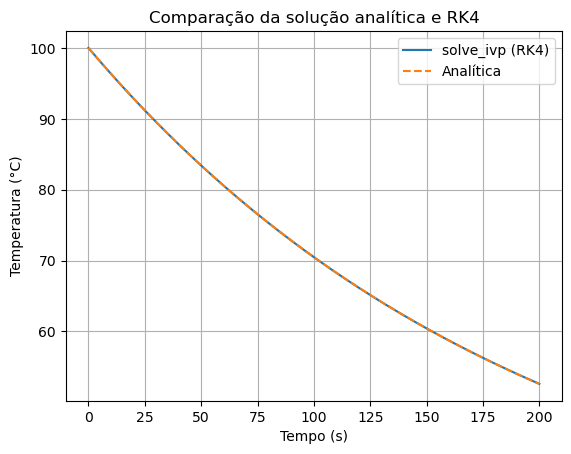

In [2]:
def dT_dt(t, T, T_amb, r):
    return r * (T_amb - T)  # Assuming ambient temperature is 20 degrees

T0 = 100  # Temperatura inicial
T_amb = 25
r = 0.005
t_span = (0, 200)
t_eval = np.linspace(*t_span, 200)

# Solução numérica
sol = solve_ivp(dT_dt, t_span, [T0], args = [T_amb, r], t_eval=t_eval)

# Solução analítica
T_analytical = T_amb + (T0 - T_amb) * np.exp(-r * t_eval)

# Plot
plt.plot(t_eval, sol.y[0], label='solve_ivp (RK4)')
plt.plot(t_eval, T_analytical, '--', label='Analítica')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Comparação da solução analítica e RK4')
plt.grid()
plt.show()



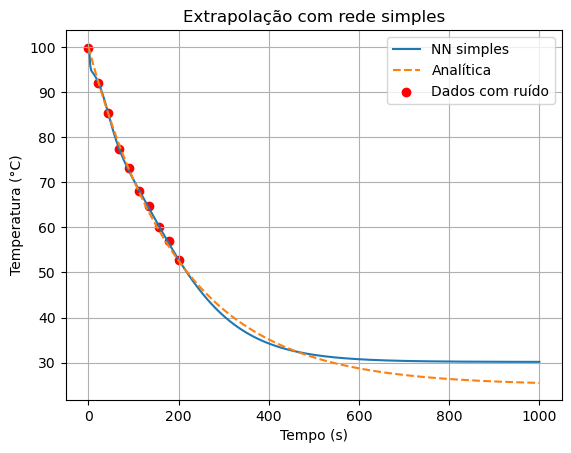

In [3]:
t_data = np.linspace(0, 200, 10)
T_data = T_amb + (T0 - T_amb) * np.exp(-r * t_data)
T_data_noisy = T_data + np.random.normal(0, 1, size=T_data.shape)

# Dados
t_train = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
T_train = torch.tensor(T_data_noisy, dtype=torch.float32).view(-1, 1)

# Rede simples
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        return self.net(t)

model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Treinamento
for epoch in range(10000): # com poucos daddos precisa de mais épocas
    optimizer.zero_grad()
    loss = loss_fn(model(t_train), T_train)
    loss.backward()
    optimizer.step()

# Avaliação
t_test = torch.linspace(0, 1000, 500).view(-1, 1)
T_pred = model(t_test).detach().numpy()

# Analítica para comparação
T_test_analytical = T_amb + (T0 - T_amb) * np.exp(-r * t_test.numpy().flatten())

# Plot
plt.plot(t_test.numpy(), T_pred, label='NN simples')
plt.plot(t_test.numpy(), T_test_analytical, '--', label='Analítica')
plt.scatter(t_data, T_data_noisy, color='red', label='Dados com ruído')
plt.legend()
plt.title('Extrapolação com rede simples')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.grid()
plt.show()

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        return self.net(t)

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Função de perda com conhecimento de r
def pinn_loss(model, t_data, T_data, r=0.005):
    T_pred = model(t_data)
    mse_data = nn.MSELoss()(T_pred, T_data)

    # Derivada
    t_phys = torch.linspace(0, 200, 100).view(-1, 1).requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = torch.autograd.grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    eq_residual = dT_dt - r * (T_amb - T_phys)
    mse_phys = torch.mean(eq_residual**2)

    return mse_data + mse_phys

# Treinamento
for epoch in range(5000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train, T_train)
    loss.backward()
    optimizer.step()

In [5]:
# Agora, r é um parâmetro treinável
r_learn = torch.tensor([0.01], requires_grad=True)

def pinn_loss_learn_r(model, t_data, T_data):
    T_pred = model(t_data)
    mse_data = nn.MSELoss()(T_pred, T_data)

    t_phys = torch.linspace(0, 200, 100).view(-1, 1).requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = torch.autograd.grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    eq_residual = dT_dt - r_learn * (T_amb - T_phys)
    mse_phys = torch.mean(eq_residual**2)

    return mse_data + mse_phys

optimizer = torch.optim.Adam(list(model.parameters()) + [r_learn], lr=1e-3)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = pinn_loss_learn_r(model, t_train, T_train)
    loss.backward()
    optimizer.step()

print(f"Valor aprendido de r: {r_learn.item():.5f}")


Valor aprendido de r: 0.00484


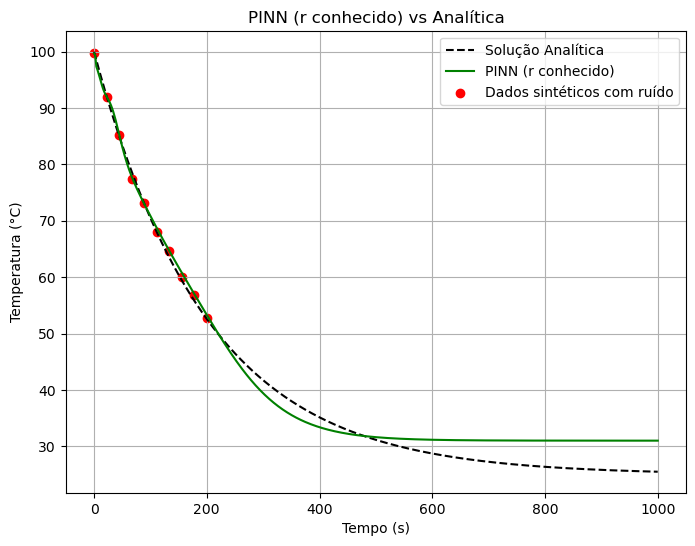

In [6]:
# Generate predictions with the trained PINN (known r)
t_test = torch.linspace(0, 1000, 500).view(-1, 1)
with torch.no_grad():
    T_pinn_known_r = model(t_test).numpy()

# Analytical solution for comparison
T_test_analytical = T_amb + (T0 - T_amb) * np.exp(-r * t_test.numpy().flatten())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_test.numpy(), T_test_analytical, '--', label='Solução Analítica', color='black')
plt.plot(t_test.numpy(), T_pinn_known_r, label='PINN (r conhecido)', color='green')
plt.scatter(t_data, T_data_noisy, color='red', label='Dados sintéticos com ruído')
plt.legend()
plt.title('PINN (r conhecido) vs Analítica')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.grid()
plt.show()


[0] Total Loss: 2286.320557 | r: 0.009000 | sigma_data: 1.0000 | sigma_phys: 1.0000 | MSE data: 4572.581055 | MSE phys: 0.059931
[500] Total Loss: 387.649780 | r: -0.000517 | sigma_data: 1.3780 | sigma_phys: 0.5993 | MSE data: 1472.958130 | MSE phys: 0.001043
[1000] Total Loss: 119.155602 | r: -0.000058 | sigma_data: 1.5817 | sigma_phys: 0.3604 | MSE data: 598.977112 | MSE phys: 0.000168
[1500] Total Loss: 49.422768 | r: 0.000000 | sigma_data: 1.6990 | sigma_phys: 0.2177 | MSE data: 291.059387 | MSE phys: 0.000051
[2000] Total Loss: 29.782892 | r: -0.000042 | sigma_data: 1.7844 | sigma_phys: 0.1318 | MSE data: 198.868652 | MSE phys: 0.000016
[2500] Total Loss: 23.573811 | r: 0.000049 | sigma_data: 1.8699 | sigma_phys: 0.0799 | MSE data: 178.139267 | MSE phys: 0.000005
[3000] Total Loss: 20.163977 | r: -0.000021 | sigma_data: 1.9706 | sigma_phys: 0.0484 | MSE data: 174.842972 | MSE phys: 0.000002
[3500] Total Loss: 17.137121 | r: -0.000090 | sigma_data: 2.0928 | sigma_phys: 0.0294 | MSE

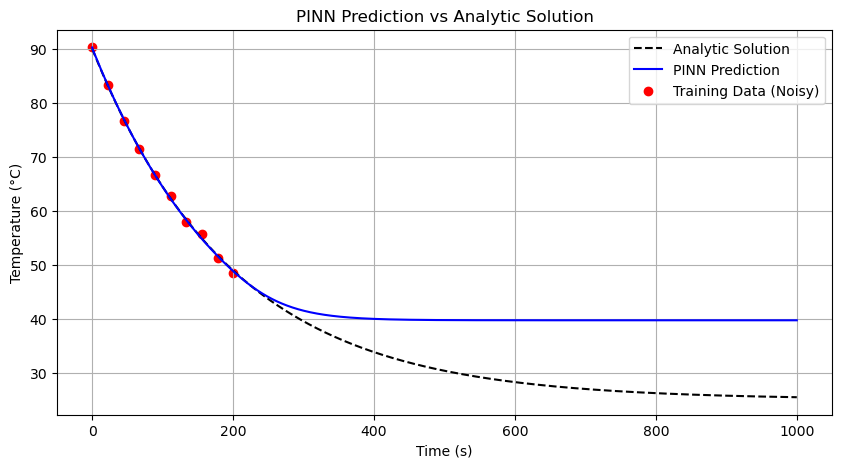

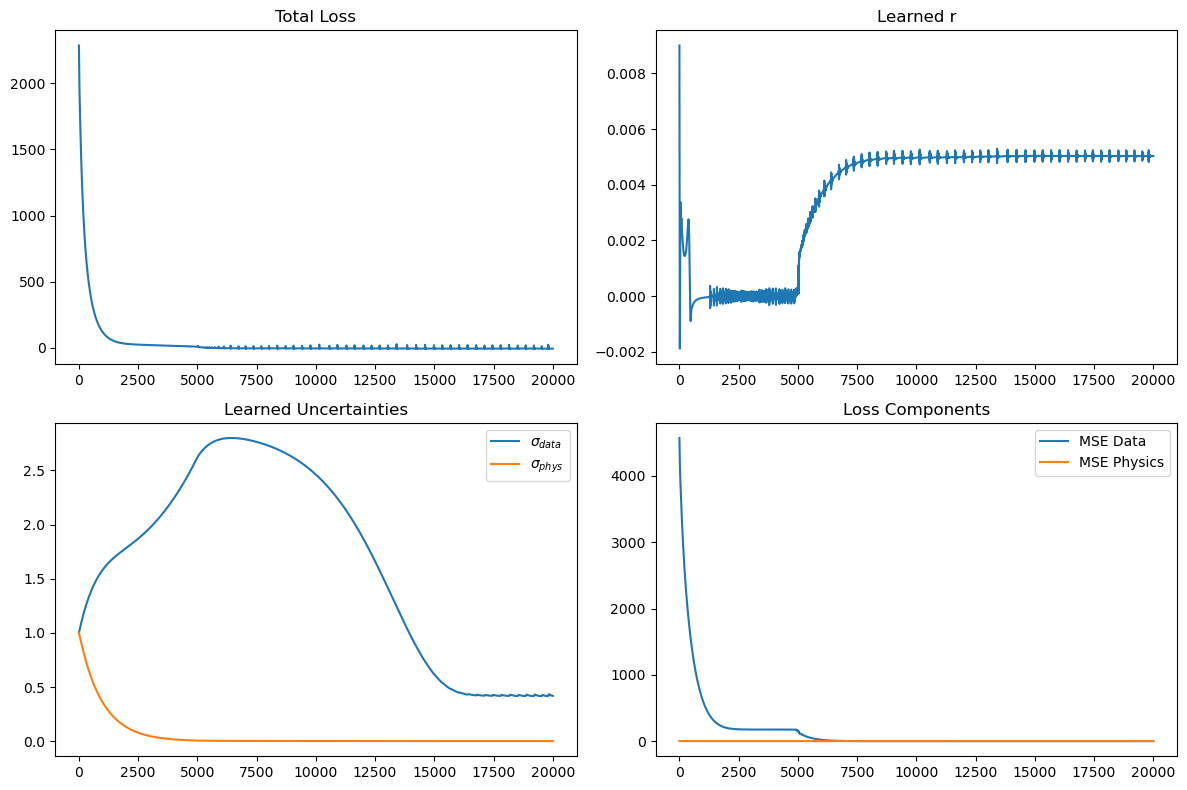

In [30]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# --------- Analytic solution for coffee cooling -------------
def analytic_solution(t, T0, r, Tamb):
    return Tamb + (T0 - Tamb) * np.exp(-r * t)

# --------- Generate synthetic noisy training data -----------
Tamb = 25.0
T0 = 90.0
r_true = 0.005

t_train_np = np.linspace(0, 200, 10)
T_clean = analytic_solution(t_train_np, T0, r_true, Tamb)
T_noisy = T_clean + np.random.normal(0, 0.5, size=T_clean.shape)

t_train = torch.tensor(t_train_np, dtype=torch.float32).view(-1,1)
T_train = torch.tensor(T_noisy, dtype=torch.float32).view(-1,1)

# --------- Define PINN neural network ------------------------
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)

# --------- Parameters to learn: r and log uncertainties -------
r_learn = torch.tensor([0.01], requires_grad=True)  # initial guess
log_sigma_data = torch.tensor([0.0], requires_grad=True)
log_sigma_phys = torch.tensor([0.0], requires_grad=True)

# --------- Loss function with uncertainty weighting ----------
def pinn_loss(model, t_data, T_data, r_param, log_sigma_data, log_sigma_phys):
    # Data loss
    T_pred = model(t_data)
    mse_data = torch.mean((T_pred - T_data)**2)

    # Physics loss
    t_phys = torch.linspace(0, 200, 200).view(-1,1).requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    residual = dT_dt - r_param * (Tamb - T_phys)
    mse_phys = torch.mean(residual**2)

    # Uncertainty weighted loss
    loss = (1/(2*torch.exp(log_sigma_data)**2)) * mse_data + \
           (1/(2*torch.exp(log_sigma_phys)**2)) * mse_phys + \
           log_sigma_data + log_sigma_phys 

    return loss, mse_data.item(), mse_phys.item(), torch.exp(log_sigma_data).item(), torch.exp(log_sigma_phys).item()

# --------- Optimizer ------------------------------------------
optimizer = torch.optim.Adam(
    list(model.parameters()) + [r_learn, log_sigma_data, log_sigma_phys],
    lr=1e-3
)

# --------- Training loop --------------------------------------
history = {'total': [], 'data': [], 'phys': [], 'r': [], 'sigma_data': [], 'sigma_phys': []}

for epoch in range(20000):
    optimizer.zero_grad()
    loss, mse_data_val, mse_phys_val, sigma_data_val, sigma_phys_val = pinn_loss(model, t_train, T_train, r_learn, log_sigma_data, log_sigma_phys)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"[{epoch}] Total Loss: {loss.item():.6f} | r: {r_learn.item():.6f} | "
              f"sigma_data: {sigma_data_val:.4f} | sigma_phys: {sigma_phys_val:.4f} | "
              f"MSE data: {mse_data_val:.6f} | MSE phys: {mse_phys_val:.6f}")

    history['total'].append(loss.item())
    history['data'].append(mse_data_val)
    history['phys'].append(mse_phys_val)
    history['r'].append(r_learn.item())
    history['sigma_data'].append(sigma_data_val)
    history['sigma_phys'].append(sigma_phys_val)

# --------- Plot predicted vs analytic solution ----------------
t_all = np.linspace(0, 1000, 1000).reshape(-1,1).astype(np.float32)
t_all_tensor = torch.tensor(t_all)

T_pinn = model(t_all_tensor).detach().numpy().flatten()
T_analytic = analytic_solution(t_all.flatten(), T0, r_true, Tamb)

plt.figure(figsize=(10,5))
plt.plot(t_all, T_analytic, 'k--', label="Analytic Solution")
plt.plot(t_all, T_pinn, 'b', label="PINN Prediction")
plt.scatter(t_train_np, T_noisy, c='red', label="Training Data (Noisy)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("PINN Prediction vs Analytic Solution")
plt.legend()
plt.grid(True)
plt.show()

# --------- Plot training stats ---------------------------------
fig, axs = plt.subplots(2,2, figsize=(12,8))

axs[0,0].plot(history['total'])
axs[0,0].set_title('Total Loss')

axs[0,1].plot(history['r'])
axs[0,1].set_title('Learned r')

axs[1,0].plot(history['sigma_data'], label=r'$\sigma_{data}$')
axs[1,0].plot(history['sigma_phys'], label=r'$\sigma_{phys}$')
axs[1,0].set_title('Learned Uncertainties')
axs[1,0].legend()

axs[1,1].plot(history['data'], label='MSE Data')
axs[1,1].plot(history['phys'], label='MSE Physics')
axs[1,1].set_title('Loss Components')
axs[1,1].legend()

plt.tight_layout()
plt.show()


[0] Loss: 4554.182129 | r: 0.009000 | λ_data: 1.0000 | λ_phys: 2.7183 | MSE data: 4550.062500 | MSE phys: 0.061412
[500] Loss: 1219.845093 | r: 0.001056 | λ_data: 0.6946 | λ_phys: 1.7984 | MSE data: 1753.669678 | MSE phys: 0.000681
[1000] Loss: 441.643616 | r: -0.000048 | λ_data: 0.5729 | λ_phys: 1.3479 | MSE data: 769.122070 | MSE phys: 0.000106
[1500] Loss: 186.880661 | r: -0.000018 | λ_data: 0.5146 | λ_phys: 1.0940 | MSE data: 361.620148 | MSE phys: 0.000039
[2000] Loss: 104.698669 | r: -0.000010 | λ_data: 0.4803 | λ_phys: 0.9435 | MSE data: 216.431442 | MSE phys: 0.000019
[2500] Loss: 80.783272 | r: -0.000006 | λ_data: 0.4524 | λ_phys: 0.8544 | MSE data: 176.759033 | MSE phys: 0.000010
[3000] Loss: 72.610542 | r: -0.000004 | λ_data: 0.4237 | λ_phys: 0.8033 | MSE data: 169.159866 | MSE phys: 0.000006
[3500] Loss: 67.071747 | r: -0.000003 | λ_data: 0.3923 | λ_phys: 0.7743 | MSE data: 168.190186 | MSE phys: 0.000003
[4000] Loss: 61.537735 | r: -0.000002 | λ_data: 0.3584 | λ_phys: 0.75

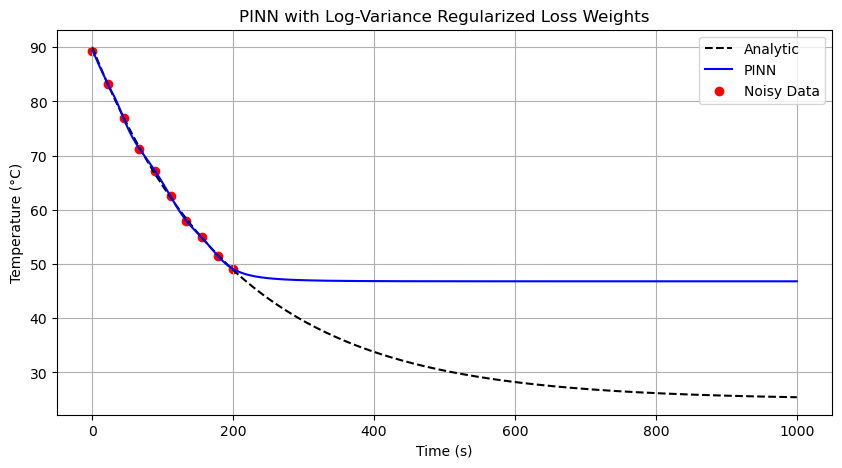

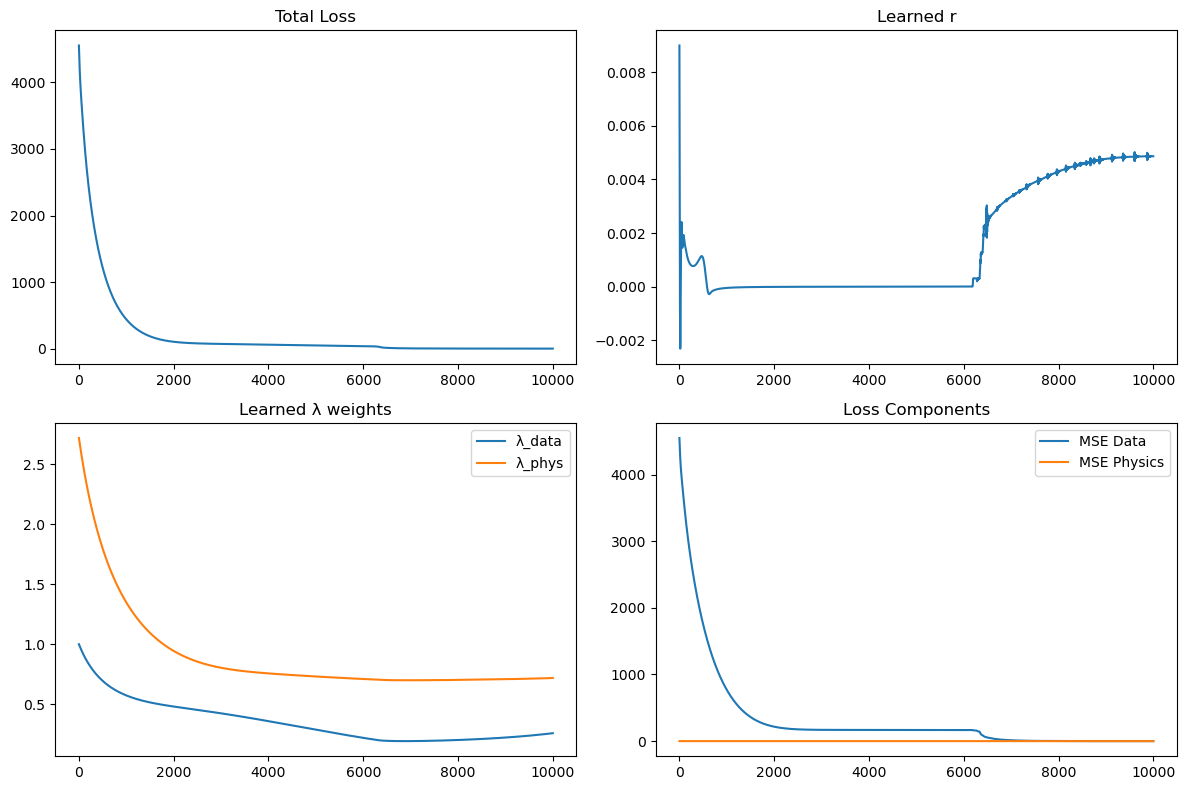

In [27]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# ----------- Analytic solution ----------------
def analytic_solution(t, T0, r, Tamb):
    return Tamb + (T0 - Tamb) * np.exp(-r * t)

# ----------- Generate synthetic data ----------
Tamb = 25.0
T0 = 90.0
r_true = 0.005

t_train_np = np.linspace(0, 200, 10)
T_clean = analytic_solution(t_train_np, T0, r_true, Tamb)
T_noisy = T_clean + np.random.normal(0, 0.5, size=T_clean.shape)

t_train = torch.tensor(t_train_np, dtype=torch.float32).view(-1, 1)
T_train = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1)

# ----------- Define NN ------------------------
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 1)
)

# ----------- Learnable parameters -------------
r_learn = torch.tensor([0.01], requires_grad=True)
log_lambda_data = torch.tensor([0.0], requires_grad=True)
log_lambda_phys = torch.tensor([1.0], requires_grad=True)

# ----------- Loss function --------------------
def loss_with_log_variance_reg(model, t_data, T_data, r_param, log_l_data, log_l_phys):
    lambda_data = torch.exp(log_l_data)
    lambda_phys = torch.exp(log_l_phys)

    T_pred = model(t_data)
    mse_data = torch.mean((T_pred - T_data) ** 2)

    t_phys = torch.linspace(0, 200, 500).view(-1, 1).requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    residual = dT_dt - r_param * (Tamb - T_phys)
    mse_phys = torch.mean(residual ** 2)
    reg = (lambda_data - lambda_phys)**2

    loss = (lambda_data) * mse_data + \
           (lambda_phys) * mse_phys + \
           log_l_data**2 + log_l_phys**2 + reg 

    return loss, mse_data.item(), mse_phys.item(), lambda_data.item(), lambda_phys.item()

# ----------- Optimizer ------------------------
optimizer = torch.optim.Adam(
    list(model.parameters()) + [r_learn, log_lambda_data, log_lambda_phys],
    lr=1e-3
)

# ----------- Training loop --------------------
history = {'total': [], 'data': [], 'phys': [], 'r': [], 'ld': [], 'lp': []}

for epoch in range(10000):
    optimizer.zero_grad()
    loss, mse_data_val, mse_phys_val, ld_val, lp_val = loss_with_log_variance_reg(
        model, t_train, T_train, r_learn, log_lambda_data, log_lambda_phys
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"[{epoch}] Loss: {loss.item():.6f} | r: {r_learn.item():.6f} | "
              f"λ_data: {ld_val:.4f} | λ_phys: {lp_val:.4f} | "
              f"MSE data: {mse_data_val:.6f} | MSE phys: {mse_phys_val:.6f}")

    history['total'].append(loss.item())
    history['data'].append(mse_data_val)
    history['phys'].append(mse_phys_val)
    history['r'].append(r_learn.item())
    history['ld'].append(ld_val)
    history['lp'].append(lp_val)

# ----------- Plot predictions -----------------
t_all = np.linspace(0, 1000, 1000).reshape(-1,1).astype(np.float32)
t_all_tensor = torch.tensor(t_all)

T_pred = model(t_all_tensor).detach().numpy().flatten()
T_true = analytic_solution(t_all.flatten(), T0, r_true, Tamb)

plt.figure(figsize=(10,5))
plt.plot(t_all, T_true, 'k--', label='Analytic')
plt.plot(t_all, T_pred, 'b', label='PINN')
plt.scatter(t_train_np, T_noisy, c='r', label='Noisy Data')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("PINN with Log-Variance Regularized Loss Weights")
plt.legend()
plt.grid()
plt.show()

# ----------- Plot training stats --------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(history['total']); axs[0,0].set_title("Total Loss")
axs[0,1].plot(history['r']); axs[0,1].set_title("Learned r")
axs[1,0].plot(history['ld'], label='λ_data'); axs[1,0].plot(history['lp'], label='λ_phys')
axs[1,0].legend(); axs[1,0].set_title("Learned λ weights")
axs[1,1].plot(history['data'], label='MSE Data'); axs[1,1].plot(history['phys'], label='MSE Physics')
axs[1,1].legend(); axs[1,1].set_title("Loss Components")
plt.tight_layout()
plt.show()
